In [1]:
import pandas as pd
import numpy as np
# from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import re
import os


In [5]:
ratings = pd.read_csv('/home/manishn/recommend/data/ml-latest-small/ratings.csv')
movies = pd.read_csv('/home/manishn/recommend/data/ml-latest-small/movies.csv')

# Merge the DataFrames on 'movieId'
merged_df = pd.merge(ratings, movies, on='movieId')
# O
merged_df = merged_df[['userId', 'movieId', 'title', 'genres', 'rating', 'timestamp']]
merged_df.head()


,userId,movieId,title,genres,rating,timestamp
0,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,964982703
1,5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,847434962
2,7,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.5,1106635946
3,15,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.5,1510577970
4,17,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.5,1305696483


In [6]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   title      100836 non-null  object 
 3   genres     100836 non-null  object 
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


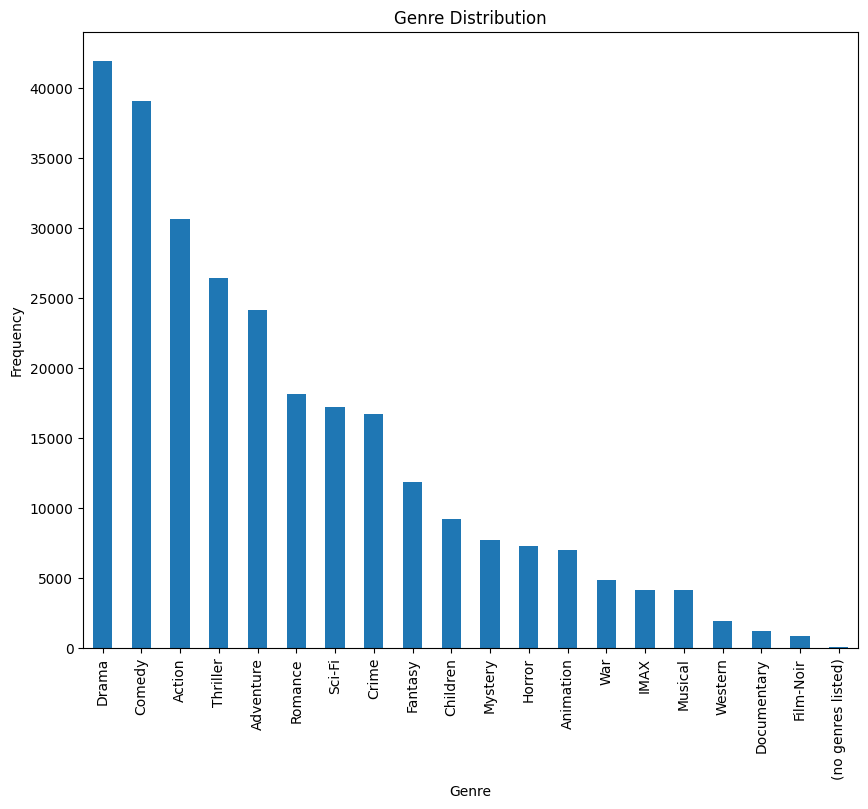

In [7]:
# Split genres and calculate the frequency
genre_data = merged_df['genres'].str.split('|', expand=True).stack().value_counts()

# Plot the genre distribution
plt.figure(figsize=(10, 8))
genre_data.plot(kind='bar')
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.show()


In [9]:
ratings_per_user = merged_df.groupby('userId').size()
print(f'Average ratings per user: {ratings_per_user.mean()}')



ratings_per_movie = merged_df.groupby('movieId').size()
print(f'Average ratings per movie: {ratings_per_movie.mean()}')


Average ratings per user: 165.30491803278687
Average ratings per movie: 10.369806663924312


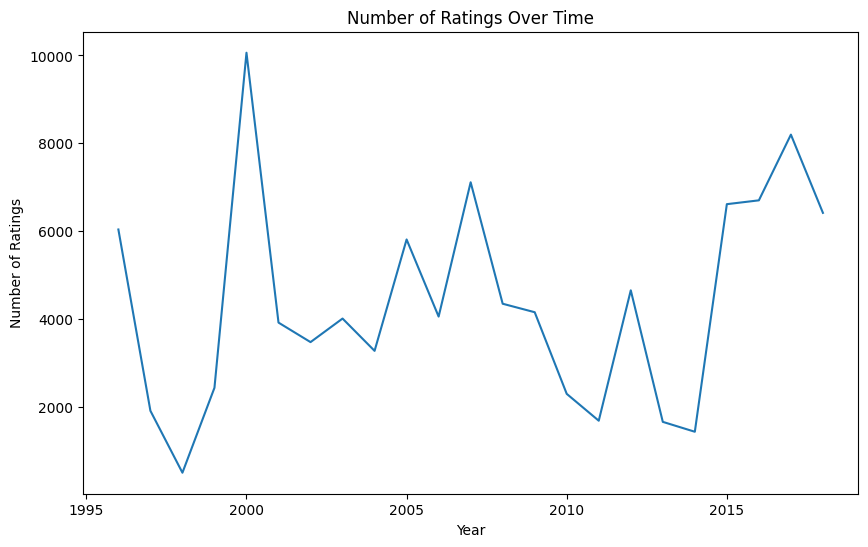

In [10]:
# Convert timestamp to datetime
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], unit='s')

# Plot ratings over time
plt.figure(figsize=(10, 6))
merged_df.groupby(merged_df['timestamp'].dt.year)['rating'].count().plot()
plt.title('Number of Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.show()


In [39]:
from collections import defaultdict

# Initialize a dictionary to store transition counts nested dictionary used below
transition_counts = defaultdict(lambda: defaultdict(int))


for user, group in merged_df.groupby('userId'):  # Iterate through each user's movie sequence
    
    movie_sequence = list(group['movieId'])  # this will Get the sequence of movies watched by the user
    
    
    for i in range(len(movie_sequence) - 1):     # Count transitions between consecutive movies and not total like 0-1-2 = 2 transitions
        current_movie = movie_sequence[i]
        next_movie = movie_sequence[i + 1]
        transition_counts[current_movie][next_movie] += 1

print(f'Transition counts from Movie 1: {transition_counts[1]}')  # For movieId = 1


Transition counts from Movie 1: defaultdict(<class 'int'>, {3: 32, 50: 21, 47: 48, 6: 42, 260: 18, 648: 2, 110: 19, 296: 8, 356: 7, 596: 1, 223: 2, 608: 1, 1198: 1, 441: 1, 231: 5, 500: 1, 70: 1, 58559: 1, 151: 1, 527: 1, 457: 1, 101: 1})


In [ ]:
# Initialize a dictionary to store transition probabilities
transition_probabilities = defaultdict(lambda: defaultdict(float))

# Convert counts to probabilities
for current_movie, transitions in transition_counts.items():
    total_transitions = sum(transitions.values())
    for next_movie, count in transitions.items():
        transition_probabilities[current_movie][next_movie] = count / total_transitions

print(f'Transition probabilities from Movie 1: {dict(transition_probabilities[1])}')


In [48]:
transition_probabilities=defaultdict(lambda:defaultdict(float))
for current_movie,transitions in transition_counts.items():
    total_transitions=sum(transitions.values())
    for mext_movies,count in transitions.items():
        transition_probabilities[current_movie][mext_movies]=count/total_transitions
print(f'Transition counts from Movie 1: {dict(transition_probabilities[1])}')  # For movieId = 1


Transition counts from Movie 1: {3: 0.14883720930232558, 50: 0.09767441860465116, 47: 0.22325581395348837, 6: 0.19534883720930232, 260: 0.08372093023255814, 648: 0.009302325581395349, 110: 0.08837209302325581, 296: 0.037209302325581395, 356: 0.03255813953488372, 596: 0.004651162790697674, 223: 0.009302325581395349, 608: 0.004651162790697674, 1198: 0.004651162790697674, 441: 0.004651162790697674, 231: 0.023255813953488372, 500: 0.004651162790697674, 70: 0.004651162790697674, 58559: 0.004651162790697674, 151: 0.004651162790697674, 527: 0.004651162790697674, 457: 0.004651162790697674, 101: 0.004651162790697674}


In [52]:
import pandas as pd

transition_matrix = pd.DataFrame(transition_probabilities).fillna(0)
print(transition_matrix.head())


       1         3         6         47        50        70        101     \
3    0.148837  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
50   0.097674  0.019231  0.137255  0.591133  0.000000  0.000000  0.000000   
47   0.223256  0.269231  0.656863  0.000000  0.000000  0.000000  0.000000   
6    0.195349  0.480769  0.000000  0.000000  0.000000  0.000000  0.000000   
260  0.083721  0.019231  0.039216  0.029557  0.098039  0.036364  0.043478   

       110       151       157     ...  147657  147662  148166  149011  \
3    0.000000  0.000000  0.000000  ...     0.0     0.0     0.0     0.0   
50   0.000000  0.000000  0.000000  ...     0.0     0.0     0.0     0.0   
47   0.000000  0.000000  0.000000  ...     0.0     0.0     0.0     0.0   
6    0.000000  0.000000  0.000000  ...     0.0     0.0     0.0     0.0   
260  0.194093  0.113636  0.090909  ...     0.0     0.0     0.0     0.0   

     152372  158721  160341  160527  160836  163937  
3       0.0     0.0     0.0     0.0   

In [51]:
#recommend the next movie based on the current movie
def recommend_next_movie(current_movie_id):
    if current_movie_id in transition_probabilities:
        # Get the next movie with the highest transition probability
        next_movie_id = max(transition_probabilities[current_movie_id], key=transition_probabilities[current_movie_id].get)
        return next_movie_id
    else:
        return None  # No transitions available

next_movie = recommend_next_movie(1)
print(f'The next recommended movie after Movie 1 is: {next_movie}')


The next recommended movie after Movie 1 is: 47


In [58]:

movie_47 = movies[movies['movieId'] == 47]
print(movie_47)


    movieId                        title            genres
43       47  Seven (a.k.a. Se7en) (1995)  Mystery|Thriller


In [59]:

movie_47 = movies[movies['movieId'] == 1]
print(movie_47)


   movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy


In [1]:
pip install numpy pandas scikit-surprise


Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp38-cp38-linux_x86_64.whl size=2916392 sha256=572a74d0e994dfe6c95b23399946e6de3cb2065a5f994dbba3444a08027825a2
  Stored in directory: /home/manishn/.cache/pip/wheels/99/34/23/b19f7de7352af5d1913f2654641432d6740c2666eecf2472ea
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import numpy as np
from collections import defaultdict
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split


In [3]:
# Load the ratings and movies datasets
ratings = pd.read_csv('/home/manishn/recommend/data/ml-latest-small/ratings.csv')
movies = pd.read_csv('/home/manishn/recommend/data/ml-latest-small/movies.csv')

# Merge the DataFrames on 'movieId'
merged_df = pd.merge(ratings, movies, on='movieId')
merged_df = merged_df[['userId', 'movieId', 'title', 'genres', 'rating', 'timestamp']]

# Sort by userId and timestamp to create sequences
merged_df = merged_df.sort_values(by=['userId', 'timestamp'])  # sort first by the userId column, and then within each userId, to sort by the timestamp column

# Display the first few rows
merged_df.head()

,userId,movieId,title,genres,rating,timestamp
5540,1,804,She's the One (1996),Comedy|Romance,4.0,964980499
7557,1,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,5.0,964980499
10740,1,2018,Bambi (1942),Animation|Children|Drama,5.0,964980523
13084,1,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,4.0,964980523
13823,1,2826,"13th Warrior, The (1999)",Action|Adventure|Fantasy,4.0,964980523


In [5]:
# Initialize a dictionary to store the transition counts
transition_counts = defaultdict(lambda: defaultdict(int))

# Iterate through each user and their movie sequence
for user, group in merged_df.groupby('userId'):
    movie_sequence = list(group['movieId'])
    for i in range(len(movie_sequence) - 1):
        current_movie = movie_sequence[i]
        next_movie = movie_sequence[i + 1]
        transition_counts[current_movie][next_movie] += 1

# Normalize the transition counts to get transition probabilities
transition_probabilities = defaultdict(lambda: defaultdict(float))

for current_movie, transitions in transition_counts.items():
    total_transitions = sum(transitions.values())
    for next_movie, count in transitions.items():
        transition_probabilities[current_movie][next_movie] = count / total_transitions

# Example: Show transition probabilities from a particular movie (movieId = 1)
print(dict(transition_probabilities[1]))


{1282: 0.013953488372093023, 597: 0.009302325581395349, 1210: 0.013953488372093023, 8961: 0.009302325581395349, 780: 0.06976744186046512, 910: 0.004651162790697674, 588: 0.013953488372093023, 595: 0.004651162790697674, 648: 0.07441860465116279, 608: 0.013953488372093023, 231: 0.013953488372093023, 553: 0.009302325581395349, 736: 0.037209302325581395, 1500: 0.004651162790697674, 593: 0.023255813953488372, 356: 0.027906976744186046, 1032: 0.004651162790697674, 480: 0.018604651162790697, 7361: 0.004651162790697674, 150: 0.009302325581395349, 2571: 0.004651162790697674, 79132: 0.004651162790697674, 3751: 0.004651162790697674, 3114: 0.027906976744186046, 1265: 0.013953488372093023, 50: 0.013953488372093023, 2: 0.004651162790697674, 1270: 0.009302325581395349, 141: 0.004651162790697674, 6377: 0.004651162790697674, 161: 0.013953488372093023, 1246: 0.004651162790697674, 2395: 0.004651162790697674, 955: 0.004651162790697674, 2501: 0.004651162790697674, 2959: 0.009302325581395349, 1517: 0.004651

In [16]:
# Use Surprise library to create a dataset
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(merged_df[['userId', 'movieId', 'rating']], reader)

# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Use the SVD algorithm for matrix factorization
algo = SVD()
algo.fit(trainset)

# Make predictions for a specific user and item
user_id = 1
movie_id = 47  # Example movieId

prediction = algo.predict(user_id, movie_id)
print(f'Predicted rating for User {user_id} for Movie {movie_id}: {prediction.est}')


Predicted rating for User 1 for Movie 47: 4.842257915197285


In [17]:
def fpmc_recommendation(user_id, current_movie_id):
    # Get the transition probabilities for the current movie
    next_movie_candidates = transition_probabilities.get(current_movie_id, {})
    
    # Get the predicted preference score for each candidate
    scores = {}
    for next_movie_id in next_movie_candidates:
        transition_prob = next_movie_candidates[next_movie_id]
        pred = algo.predict(user_id, next_movie_id).est
        # Combine the transition probability with the preference score
        scores[next_movie_id] = pred + transition_prob
    
    # Recommend the movie with the highest combined score
    if scores:
        recommended_movie = max(scores, key=scores.get)
        return recommended_movie
    return None

# Example recommendation for a user and current movie
current_movie_id = 1  # Example movie
next_movie = fpmc_recommendation(user_id=1, current_movie_id=current_movie_id)
print(f'Recommended next movie after {current_movie_id}: {next_movie}')


Recommended next movie after 1: 50
